In [1]:
import iris
import glob
import iris.plot as iplt
import iris.quickplot as qplt
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import numpy as np
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
import iris
import glob
import iris.plot as iplt
import iris.quickplot as qplt
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import numpy as np

# Get year from input of running the script 
# year = sys.argv[1]
# print (year)
years = [2016]

for year in years:
    print(year)
    ### Get list of files to convert
    radardir = f'/nfs/a319/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    file_list=glob.glob(radardir +"*.nc")
    sorted_list = sorted(file_list)
    
    for i in range(0,len(sorted_list)):
        print(i)
        ### Load radar data for one day (using IRIS)
        day_cube = iris.load_cube(sorted_list[i])

        ### Add additional time based variables
        # cat.add_year(day_cube, 'time', name='year')
        # cat.add_month(day_cube, 'time', name='month')
        # cat.add_day_of_month(day_cube, 'time', name='day_of_month')
        cat.add_hour(day_cube, 'time', name='hour')
        # cat.add_day(day_cube, 'time', name='day')

        ### Aggregate to half hourly values (means)
        firsthalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute <30)
        secondhalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute >=30)

        # Create empty cube list to populate
        my_cube_list = iris.cube.CubeList()

        # Get list of the hours
        hours = set(day_cube.coord('hour').points)
        # Loop through the hours
        for hour in hours:

            # Establish constraint to select only this hour
            hour_constraint = iris.Constraint(time=lambda cell: cell.point.hour == hour)
            # Use constraint to select only this hour
            hour_cube = day_cube.extract(hour_constraint)
            # Check the times
            # times = hour_cube.coord('time').points
            # times = [datetime.datetime.fromtimestamp(x ) for x in times]

            # Get only cubes which fall within the first half of the hour and then the second half of the hour
            first_half_of_hour = hour_cube.extract(firsthalfof_hour_constraint)
            second_half_of_hour = hour_cube.extract(secondhalfof_hour_constraint)

            # If there are at least 4 values
            # Find the mean across first/second halves of hour
            # Add to cube list
            if first_half_of_hour == None:
                print("no values in 1st half hour")
            elif len(first_half_of_hour.shape) ==2:
                print("only 1 value in 1st half hour")        
            else:
                
                if first_half_of_hour.shape[0] >=4:
                    ## Correct negative 1064 values to np.nan
                    if np.nanmin(first_half_of_hour.data)<0:
                        print(f"iter {i}, hour {hour}, first half hour, min value is: {np.nanmin(first_half_of_hour.data)}")
                        first_half_of_hour.data = np.where(first_half_of_hour.data <0, np.nan, first_half_of_hour.data)
                        print(f"min value is: {np.nanmin(first_half_of_hour.data)}")
                        if np.nanmin(first_half_of_hour.data <0):
                            print(first_half_of_hour.data[first_half_of_hour.data<0])
                    # FIND MEAN ACROSS WHOLE FIRST HALF HOUR
                    first_half_hourly_mean = first_half_of_hour.aggregated_by(['hour'],iris.analysis.MEAN)
                    # first_half_hourly_mean.data.astype('float64')
                    my_cube_list.append(first_half_hourly_mean)
                else:
                    print(f"only {first_half_of_hour.shape[0]} vals in 1st half hour")

            ### SECOND HALF HOUR    
            if second_half_of_hour == None:
                print("no values in 2nd half hour")
            elif len(second_half_of_hour.shape) ==2:
                print("only 1 value in 2nd half hour")
            else:
                if second_half_of_hour.shape[0] >=4:    
                    ## Correct negative 1064 values to np.nan
                    if np.nanmin(second_half_of_hour.data)<0:            
                        print(f"iter {i}, hour {hour}, second half hour, min value is: {np.nanmin(second_half_of_hour.data)}")
                        second_half_of_hour.data = np.where(second_half_of_hour.data <0, np.nan, second_half_of_hour.data)
                        print(f"min value is: {np.nanmin(second_half_of_hour.data)}")
                        if np.nanmin(second_half_of_hour.data <0):
                            print(second_half_of_hour.data[second_half_of_hour.data<0])
                    # FIND MEAN ACROSS WHOLE FIRST HALF HOUR
                    second_half_hourly_mean = second_half_of_hour.aggregated_by(['hour'],iris.analysis.MEAN)
                    # second_half_hourly_mean.data.astype('float64')
                    my_cube_list.append(second_half_hourly_mean)
                else:
                    print(f"only {second_half_of_hour.shape[0]} vals in 2nd half hour")


        ### Join back into one cube covering the whole day
        try:
            for halfhour_i in range(0,len(my_cube_list)):
                my_cube_list[halfhour_i].data = my_cube_list[halfhour_i].data.astype('float64')

            thirty_mins_means = my_cube_list.concatenate_cube()
            print(thirty_mins_means.shape)

            # Get rid of high values which are fill values
            thirty_mins_means.data = np.where(thirty_mins_means.data >1e+36, np.nan, thirty_mins_means.data)

            # save 
            new_fp = sorted_list[i][:-3]+ '_30mins.nc'
            new_fp = new_fp.replace('5mins', '30mins')
            iris.save(thirty_mins_means, new_fp)
            print(f'Saved cube {year} {i}')
            print(np.nanmin(thirty_mins_means.data))
            print(np.nanmax(thirty_mins_means.data))
            print(np.nanmean(thirty_mins_means.data))

        except:
            pass

2016
0
(48, 2175, 1725)
Saved cube 2016 0
0.0
170.81770833333334
0.00494370656685548
1
(48, 2175, 1725)
Saved cube 2016 1
0.0
170.66145833333334
0.004875179814606572
2
(48, 2175, 1725)
Saved cube 2016 2
0.0
170.78125
0.00727856713136485
3
(48, 2175, 1725)
Saved cube 2016 3
0.0
170.703125
0.0011222874558091311
4
(48, 2175, 1725)
Saved cube 2016 4
0.0
246.109375
0.0030999019500666373
5
(48, 2175, 1725)
Saved cube 2016 5
0.0
395.1979166666667
0.019703704311038926
6
(48, 2175, 1725)
Saved cube 2016 6
0.0
457.6875
0.02798262555065049
7
(48, 2175, 1725)
Saved cube 2016 7
0.0
170.765625
0.006115355869518918
8
(48, 2175, 1725)
Saved cube 2016 8
0.0
253.71354166666666
0.019863734672015916
9
(48, 2175, 1725)
Saved cube 2016 9
0.0
170.85416666666666
0.04653005171025597
10
(48, 2175, 1725)
Saved cube 2016 10
0.0
171.00520833333334
0.03048826765147509
11
(48, 2175, 1725)
Saved cube 2016 11
0.0
170.73958333333334
0.04022121686552562
12
(48, 2175, 1725)
Saved cube 2016 12
0.0
171.13541666666666
0.035

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

In [59]:
i = 56
### Load radar data for one day (using IRIS)
day_cube = iris.load_cube(sorted_list[i])

### Add additional time based variables
# cat.add_year(day_cube, 'time', name='year')
# cat.add_month(day_cube, 'time', name='month')
# cat.add_day_of_month(day_cube, 'time', name='day_of_month')
cat.add_hour(day_cube, 'time', name='hour')
# cat.add_day(day_cube, 'time', name='day')

### Aggregate to half hourly values (means)
firsthalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute <30)
secondhalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute >=30)

# Create empty cube list to populate
my_cube_list = iris.cube.CubeList()

# Get list of the hours
hours = set(day_cube.coord('hour').points)
# Loop through the hours



### Join back into one cube covering the whole day
try:
    for halfhour_i in range(0,len(my_cube_list)):
        my_cube_list[halfhour_i].data = my_cube_list[halfhour_i].data.astype('float64')

    thirty_mins_means = my_cube_list.concatenate_cube()

    # Get rid of high values which are fill values
    thirty_mins_means.data = np.where(thirty_mins_means.data >1e+36, np.nan, thirty_mins_means.data)

    # save 
    new_fp = sorted_list[i][:-3]+ '_30mins.nc'
    new_fp = new_fp.replace('5mins', '30mins')
    iris.save(thirty_mins_means, new_fp)
    print(f'Saved cube {year} {i}')
    print(np.nanmin(thirty_mins_means.data))
    print(np.nanmax(thirty_mins_means.data))
    print(np.nanmean(thirty_mins_means.data))

except:
    pass

In [60]:
for hour in hours:
    print(hour)

    # Establish constraint to select only this hour
    hour_constraint = iris.Constraint(time=lambda cell: cell.point.hour == hour)
    # Use constraint to select only this hour
    hour_cube = day_cube.extract(hour_constraint)
    # Check the times
    # times = hour_cube.coord('time').points
    # times = [datetime.datetime.fromtimestamp(x ) for x in times]

    # Get only cubes which fall within the first half of the hour and then the second half of the hour
    first_half_of_hour = hour_cube.extract(firsthalfof_hour_constraint)
    second_half_of_hour = hour_cube.extract(secondhalfof_hour_constraint)

    # If there are at least 4 values
    # Find the mean across first/second halves of hour
    # Add to cube list
    if first_half_of_hour == None:
        print("no values in 1st half hour")
    elif len(first_half_of_hour.shape) ==2:
        print("only 1 value in 1st half hour")        
    else:

        if first_half_of_hour.shape[0] >=4:
            ## Correct negative 1064 values to np.nan
            if np.nanmin(first_half_of_hour.data)<0:
                print(f"iter {i}, hour {hour}, first half hour, min value is: {np.nanmin(first_half_of_hour.data)}")
                first_half_of_hour.data = np.where(first_half_of_hour.data <0, np.nan, first_half_of_hour.data)
                print(f"min value is: {np.nanmin(first_half_of_hour.data)}")
                if np.nanmin(first_half_of_hour.data <0):
                    print(first_half_of_hour.data[first_half_of_hour.data<0])
            # FIND MEAN ACROSS WHOLE FIRST HALF HOUR
            first_half_hourly_mean = first_half_of_hour.aggregated_by(['hour'],iris.analysis.MEAN)
            print(np.nanmax(first_half_hourly_mean.data))
            # first_half_hourly_mean.data.astype('float64')
            my_cube_list.append(first_half_hourly_mean)
        else:
            print(f"only {first_half_of_hour.shape[0]} vals in 1st half hour")

    ### SECOND HALF HOUR    
    if second_half_of_hour == None:
        print("no values in 2nd half hour")
    elif len(second_half_of_hour.shape) ==2:
        print("only 1 value in 2nd half hour")
    else:
        if second_half_of_hour.shape[0] >=4:    
            ## Correct negative 1064 values to np.nan
            if np.nanmin(second_half_of_hour.data)<0:            
                print(f"iter {i}, hour {hour}, second half hour, min value is: {np.nanmin(second_half_of_hour.data)}")
                second_half_of_hour.data = np.where(second_half_of_hour.data <0, np.nan, second_half_of_hour.data)
                print(f"min value is: {np.nanmin(second_half_of_hour.data)}")
                if np.nanmin(second_half_of_hour.data <0):
                    print(second_half_of_hour.data[second_half_of_hour.data<0])
            # FIND MEAN ACROSS WHOLE FIRST HALF HOUR
            second_half_hourly_mean = second_half_of_hour.aggregated_by(['hour'],iris.analysis.MEAN)
            print(np.nanmax(second_half_hourly_mean.data))
            # second_half_hourly_mean.data.astype('float64')
            my_cube_list.append(second_half_hourly_mean)
        else:
            print(f"only {second_half_of_hour.shape[0]} vals in 2nd half hour")

0
57.828125
171.13020833333334
1
104.4375
56.640625
2
33.765625
49.802083333333336
3
58.15625
7.677083333333333
4
38.885416666666664
171.90104166666666
5
28.84375
54.020833333333336
6
14.25
19.78125
7
23.1875
31.046875
8
38.890625
56.796875
9
31.796875
16.151041666666668
10
32.515625
34.625
11
23.28125
33.390625
12
37.171875
27.776041666666668
13
36.119791666666664
56.833333333333336
14
52.46875
86.15625
15
50.09375
17.947916666666668
16
39.4375
40.140625
17
30.15625
50.703125
18
10.75
19.354166666666668
19
70.296875
77.11458333333333
20
96.28125
156.17708333333334
21
33.65625
99.75520833333333
22
120.82291666666667
171.63541666666666
23
88.05208333333333
170.66145833333334


In [61]:
my_cube_list

Rainfall Rate Composite (mm/h),time,projection_y_coordinate,projection_x_coordinate
Shape,1,2175,1725
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
forecast_reference_time,x,-,-
hour,x,-,-
Scalar coordinates,,,forecast_period 0 second
Cell methods,,,


In [16]:
hour = 17

# Establish constraint to select only this hour
hour_constraint = iris.Constraint(time=lambda cell: cell.point.hour == hour)
# Use constraint to select only this hour
hour_cube = day_cube.extract(hour_constraint)
# Check the times
# times = hour_cube.coord('time').points
# times = [datetime.datetime.fromtimestamp(x ) for x in times]

# Get only cubes which fall within the first half of the hour and then the second half of the hour
first_half_of_hour = hour_cube.extract(firsthalfof_hour_constraint)
second_half_of_hour = hour_cube.extract(secondhalfof_hour_constraint)

# If there are at least 4 values
# Find the mean across first/second halves of hour
# Add to cube list
if first_half_of_hour == None:
    print("no values in 1st half hour")
elif len(first_half_of_hour.shape) ==2:
    print("only 1 value in 1st half hour")        
else:

    if first_half_of_hour.shape[0] >=4:
        ## Correct negative 1064 values to np.nan
        if np.nanmin(first_half_of_hour.data)<0:
            print(f"iter {i}, hour {hour}, first half hour, min value is: {np.nanmin(first_half_of_hour.data)}")
            first_half_of_hour.data = np.where(first_half_of_hour.data <0, np.nan, first_half_of_hour.data)
            print(f"min value is: {np.nanmin(first_half_of_hour.data)}")
            if np.nanmin(first_half_of_hour.data <0):
                print(first_half_of_hour.data[first_half_of_hour.data<0])
        # FIND MEAN ACROSS WHOLE FIRST HALF HOUR
        first_half_hourly_mean = first_half_of_hour.aggregated_by(['hour'],iris.analysis.MEAN)
        print(np.nanmax(first_half_hourly_mean.data))
        # first_half_hourly_mean.data.astype('float64')
        my_cube_list.append(first_half_hourly_mean)
    else:
        print(f"only {first_half_of_hour.shape[0]} vals in 1st half hour")


1023.96875


In [47]:
print(np.nanmax(first_half_of_hour[0].data))
print(np.nanmax(first_half_of_hour[3].data))

1023.96875
1023.96875


In [55]:
# Find the indices where the value is 1023
indices = np.where(first_half_of_hour[3].data == 1023.96875)

# The variable indices will contain a tuple of arrays corresponding to the indices
# along each dimension where the value 1023 occurs.

# If you want to print these indices:
print("Indices where the value 1023 occurs:")
for idx in zip(*indices):
    print(idx)

Indices where the value 1023 occurs:
(955, 336)
(955, 337)
(955, 338)
(956, 335)
(956, 336)
(956, 337)
(956, 338)
(957, 335)
(957, 336)
(957, 338)
(957, 339)
(957, 340)


In [56]:
# Find the indices where the value is 1023
indices = np.where(first_half_of_hour[0].data == 1023.96875)

# The variable indices will contain a tuple of arrays corresponding to the indices
# along each dimension where the value 1023 occurs.

# If you want to print these indices:
print("Indices where the value 1023 occurs:")
for idx in zip(*indices):
    print(idx)

Indices where the value 1023 occurs:
(955, 336)
(956, 335)
(956, 336)
(957, 335)
(957, 340)


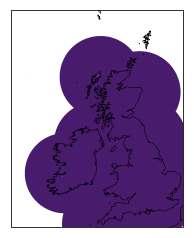

In [58]:
### Check plotting
iplt.contourf(first_half_hourly_mean_uk[0])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [30]:
# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *
uk_gdf = create_uk_outline({'init' :'epsg:3857'})

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is d

In [36]:
first_half_hourly_mean
first_half_hourly_mean_uk = trim_to_bbox_of_region_obs(first_half_hourly_mean, uk_gdf)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<autho

In [38]:
np.nanmax(first_half_hourly_mean_uk.data)

1023.96875

In [62]:
try:
    for halfhour_i in range(0,len(my_cube_list)):
        my_cube_list[halfhour_i].data = my_cube_list[halfhour_i].data.astype('float64')

    thirty_mins_means = my_cube_list.concatenate_cube()

    # Get rid of high values which are fill values
    thirty_mins_means.data = np.where(thirty_mins_means.data >1e+36, np.nan, thirty_mins_means.data)

    # save 
    new_fp = sorted_list[i][:-3]+ '_30mins.nc'
    new_fp = new_fp.replace('5mins', '30mins')
    iris.save(thirty_mins_means, new_fp)
    print(f'Saved cube {year} {i}')
    print(np.nanmin(thirty_mins_means.data))
    print(np.nanmax(thirty_mins_means.data))
    print(np.nanmean(thirty_mins_means.data))

except:
    pass

Saved cube 2011 56
0.0
171.90104166666666
0.006052826997959348
